In [33]:
import torch
import os
import numpy as np
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from math import sqrt

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [3]:
batch_size = 64
num_workers = 1
shuffle = True

image_width = 256
image_height = 256

num_epochs = 11
lr = 0.0002
k = 2

In [6]:
dataset_dir = '../storage/data/AS_storage/facades'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

In [23]:
class FacadesDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(root)))

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, self.imgs[idx])
        img = np.array(Image.open(img_path).convert("RGB"))
        
        # split image to source and target
        h, w, d = img.shape
        w = w // 2
        real_image = img[:, :w, :]
        input_image = img[:, w:, :]

        # apply preprocessing transforms
        if self.transforms is not None:
            input_image = self.transforms(Image.fromarray(input_image))
            real_image = self.transforms(Image.fromarray(real_image))
            
        return input_image, real_image

    def __len__(self):
        return len(self.imgs)

In [24]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((268,268)),
    torchvision.transforms.RandomCrop((image_width, image_height)),
    torchvision.transforms.Lambda(lambda img: (np.array(img) / 127.5) -1),
    torchvision.transforms.ToTensor()
])

In [25]:
train_set = FacadesDataset(root=train_dir, transforms=transforms)
test_set = FacadesDataset(root=test_dir, transforms=transforms)
val_set = FacadesDataset(root=val_dir, transforms=transforms)

In [26]:
len(train_set), len(test_set), len(val_set)

(400, 106, 100)

In [27]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set,batch_size,shuffle, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle, num_workers=num_workers)

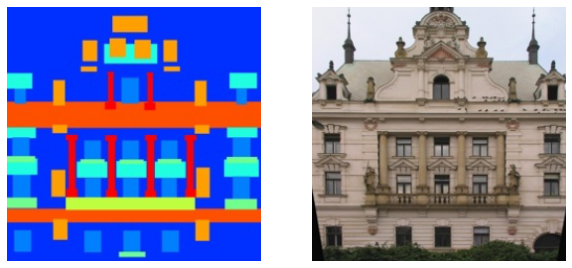

In [41]:
# load a batch
src_imgs, tgt_imgs = next(iter(train_loader))


# visualize batch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))

ax1.axis("off")
ax2.axis("off")

ax1.imshow(np.transpose((src_imgs[0]+1)/2, (1, 2, 0)))
ax2.imshow(np.transpose((tgt_imgs[0]+1)/2, (1, 2, 0)));

In [42]:
# Downsample Block
def ConvBlock(in_filters, out_filters, kernel, batch_norm, padding):
    if batch_norm:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )
    else:    
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.LeakyReLU(0.2)
        )

In [43]:
# Upsample Block
def ConvTransBlock(in_filters, out_filters, kernel, dropout, padding):
    if dropout:
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.Dropout2d(0.5),
            torch.nn.LeakyReLU(0.2)
        )
    else:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )

In [44]:
# Generator Class
class Generator(torch.nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.unet_down = torch.nn.Sequential(
            ConvBlock(3, 64, 4, False, 1), # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1), # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1), # (bs, 32, 32, 256)
            ConvBlock(256, 512, 4, True, 1), # (bs, 16, 16, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 8, 8, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 4, 4, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 2, 2, 512)
            ConvBlock(512, 512, 4, True, 1) # (bs, 1, 1, 512)
        )
        
        self.unet_up = torch.nn.Sequential(
            ConvTransBlock(512, 512, 4, True, 1), # (bs, 2, 2, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 4, 4, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 8, 8, 1024)
            ConvTransBlock(1024, 512, 4, False, 13), # (bs, 16, 16, 1024)
            ConvTransBlock(1024, 256, 4, False, 25), # (bs, 32, 32, 512)
            ConvTransBlock(512, 128, 4, False, 49), # (bs, 64, 64, 256)
            ConvTransBlock(256, 64, 4, False, 97) # (bs, 128, 128, 128)
        )
        
        self.last = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=3,
                kernel_size=2,
                stride=2,
                padding=0,
                bias=False
            ),
            torch.nn.Tanh()
        )
    
    def forward(self, inputs):
        
        skips = []
        for layer in self.unet_down:
            outputs = layer(inputs)
            skips.append(outputs)
            inputs = outputs
        
        rev_skips = reversed(skips[:-1])  # notice down has one more layer than up path
        
        for layer, skip in zip(self.unet_up, rev_skips):
            outputs = layer(inputs)  # first layer in upward takes the output from down directly w/o concat
            inputs = torch.cat(
                (outputs, skip), 1
            )
        
        return self.last(inputs)
            

In [45]:
# Discriminator Class ( Patch GAN )
# Every 70x70x3 patch is represented by a 30x30x1 output 

class Discriminator(torch.nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.net = torch.nn.Sequential(
            ConvBlock(6, 64, 4, False, 1),  # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1),  # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1),  # (bs, 32, 32, 256)
            torch.nn.ZeroPad2d(padding=1),  # (bs, 34, 34, 256)
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=4,
                stride=1,
                bias=False
            ),  # (bs, 31, 31, 512)
            torch.nn.BatchNorm2d(
                num_features=512
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ZeroPad2d(padding=1),  # (bs, 33, 33, 512)
            torch.nn.Conv2d(
                in_channels=512,
                out_channels=1,
                kernel_size=4,
                stride=1,
                bias=False
            ),  # (bs, 30, 30, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, inputs):
        return self.net(inputs)

In [46]:
# Initialize Models
netD = Discriminator().to(device)
netG = Generator().to(device)

# Optimizers
optimizerD = torch.optim.Adam(
    netD.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

optimizerG = torch.optim.Adam(
    netG.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

In [47]:
# Objective Function ( Loss Function )

Lambda = 100  # according to paper authors
bce_loss = torch.nn.BCELoss()
mae_loss = torch.nn.L1Loss()

real_labels = torch.ones(batch_size, 1, 30, 30).to(device)
fake_labels = torch.zeros(batch_size, 1, 30, 30).to(device)

In [48]:
# Train Discriminator

def trainD(src_images, tgt_images):

    src_images = src_images.to(device).float()
    tgt_images = tgt_images.to(device).float()

    fake_images = netG(src_images)

    optimizerD.zero_grad()

    real_outputs = netD(
        torch.cat(
            (src_images, tgt_images), 1
        )
    )
    fake_outputs = netD(
        torch.cat(
            (src_images, fake_images), 1
        )
    )
    d_x = bce_loss(real_outputs, real_labels)
    d_g_z = bce_loss(fake_outputs, fake_labels)
    
    loss = d_x + d_g_z

    loss.backward()

    optimizerD.step()

    return loss

In [49]:
# Train Generator

def trainG(src_images, tgt_images):

    src_images = src_images.to(device).float()
    tgt_images = tgt_images.to(device).float()

    netG.zero_grad()
    
    fake_images = netG(src_images)

    outputs = netD(
        torch.cat(
            (src_images, fake_images), 1
        )
    )

    loss_a = bce_loss(outputs, real_labels)
    loss_b = mae_loss(fake_images, tgt_images)
    
    loss = loss_a + (Lambda * loss_b)

    loss.backward()

    optimizerG.step()

    return loss

In [52]:
from math import floor


# https://pytorch.org/docs/stable/tensorboard.html
from torch.utils.tensorboard import SummaryWriter


# Writer will output to ./runs/ directory by default
tb_writer = SummaryWriter()


# fixed inputs
fixed_inputs, _ = next(iter(train_loader))
fixed_inputs = fixed_inputs.to(device).float()


import os

# checkpoints
if os.path.exists('section-6-pix2pix-optim-d.pytorch'):
    optimizerD.load_state_dict(torch.load('section-6-pix2pix-optim-d.pytorch'))
    
if os.path.exists('section-6-pix2pix-optim-g.pytorch'):
    optimizerG.load_state_dict(torch.load('section-6-pix2pix-optim-g.pytorch'))

if os.path.exists('section-6-pix2pix-network-d.pytorch'):
    netD.load_state_dict(torch.load('section-6-pix2pix-network-d.pytorch'))

if os.path.exists('section-6-pix2pix-network-g.pytorch'):
    netG.load_state_dict(torch.load('section-6-pix2pix-network-g.pytorch'))



num_steps = len(train_set) // batch_size

for epoch in range(num_epochs):
    
    d_loss = 0
    g_loss = 0
    
    for i, (src_images, tgt_images) in enumerate(train_loader):

        if i == num_steps:
            break

        for k in range(k):
            
            d_loss += trainD(
                 src_images,
                 tgt_images
            )
        
        d_loss /= 2

        g_loss += trainG(src_images, tgt_images)

    
    # Log & save checkpoint only every X epochs
    if epoch % 10 == 0:
        
        # G & D Loss
        print(
            "E:{}, G Loss:{}, D Loss:{}".format(
                epoch,
                g_loss / num_steps,
                d_loss / num_steps
            )
        )
        
        # checkpoints
        torch.save(optimizerD.state_dict(), 'section-6-pix2pix-optim-d.pytorch')
        torch.save(optimizerG.state_dict(), 'section-6-pix2pix-optim-g.pytorch')
        torch.save(netD.state_dict(), 'section-6-pix2pix-network-d.pytorch')
        torch.save(netG.state_dict(), 'section-6-pix2pix-network-g.pytorch')
                
        generated = netG(fixed_inputs).detach().cpu()

        grid = torchvision.utils.make_grid(
            generated,
            nrow=5,
            padding=10,
            pad_value=1,
            normalize=True
        )

        tb_writer.add_image(
            'Pix2Pix/Output',
            grid,
            epoch
        )

E:0, G Loss:43.42193603515625, D Loss:0.0
E:10, G Loss:38.2506217956543, D Loss:0.0
